In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


# Path to processed CSV
processed_path = r"C:\Users\vande\becode\immo-eliza-cats-analysis\Nancy\Data_quality.csv"

# Load CSV into a DataFrame
df = pd.read_csv(processed_path)

# Quick look at the data
df.head()

,id,price,property_type,subproperty_type,region,province,locality,zip_code,latitude,longitude,...,fl_garden,garden_sqm,fl_swimming_pool,fl_floodzone,state_building,primary_energy_consumption_sqm,epc,heating_type,fl_double_glazing,cadastral_income
0,34221000,225000.0,APARTMENT,APARTMENT,Flanders,Antwerp,Antwerp,2050,51.217172,4.379982,...,0,0.0,0,0,MISSING,231.0,C,GAS,1,922.0
1,2104000,449000.0,HOUSE,HOUSE,Flanders,East Flanders,Gent,9185,51.174944,3.845248,...,0,0.0,0,0,MISSING,221.0,C,MISSING,1,406.0
2,34036000,335000.0,APARTMENT,APARTMENT,Brussels-Capital,Brussels,Brussels,1070,50.842043,4.334543,...,0,0.0,0,1,AS_NEW,NaN,MISSING,GAS,0,NaN
3,58496000,501000.0,HOUSE,HOUSE,Flanders,Antwerp,Turnhout,2275,51.238312,4.817192,...,0,0.0,0,1,MISSING,99.0,A,MISSING,0,NaN
4,48727000,982700.0,APARTMENT,DUPLEX,Wallonia,Walloon Brabant,Nivelles,1410,NaN,NaN,...,1,142.0,0,0,AS_NEW,19.0,A+,GAS,0,NaN


In [2]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation with price
corr_with_price = numeric_df.corr()['price'].sort_values(ascending=False)

corr_with_price


price                             1.000000
nbr_bedrooms                      0.352447
total_area_sqm                    0.199650
fl_swimming_pool                  0.196067
latitude                          0.166984
surface_land_sqm                  0.149360
nbr_frontages                     0.146034
terrace_sqm                       0.114349
garden_sqm                        0.087180
fl_furnished                      0.031235
fl_terrace                        0.031061
fl_garden                         0.030632
cadastral_income                  0.003602
fl_double_glazing                 0.002791
id                                0.001680
primary_energy_consumption_sqm   -0.001672
fl_open_fire                     -0.010962
construction_year                -0.025081
zip_code                         -0.036045
fl_floodzone                     -0.063545
longitude                        -0.091013
Name: price, dtype: float64

In [3]:
## Select only categorical columns
binary_numeric_cols = [
    col for col in df.columns
    if df[col].nunique() == 2 and pd.api.types.is_numeric_dtype(df[col])
]

df[binary_numeric_cols + ["price"]].corr()["price"].sort_values(ascending=False)


price                1.000000
fl_swimming_pool     0.196067
fl_furnished         0.031235
fl_terrace           0.031061
fl_garden            0.030632
fl_double_glazing    0.002791
fl_open_fire        -0.010962
fl_floodzone        -0.063545
Name: price, dtype: float64

In [4]:
region_dummies = pd.get_dummies(df["region"], drop_first=True)

corr_region = region_dummies.join(df["price"]).corr()["price"].sort_values(ascending=False)
corr_region


price       1.000000
Flanders    0.083200
MISSING     0.005453
Wallonia   -0.152434
Name: price, dtype: float64

In [5]:
# Capping and log transformations

df_before = df.copy() #Keeping a copy of data before capping
cap_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']
lower_cap = 0.01
upper_cap = 0.99
for var in cap_vars:
    lower = df[var].quantile(lower_cap)
    upper = df[var].quantile(upper_cap)
    df[var] = np.where(df[var] < lower, lower,
                       np.where(df[var] > upper, upper, df[var]))

# Initiating the log transfiormations
log_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df[[f'{v}_log' for v in log_vars]].skew()

price_log               0.633031
surface_land_sqm_log   -1.389089
total_area_sqm_log      0.358966
garden_sqm_log          1.949206
terrace_sqm_log         0.382161
dtype: float64

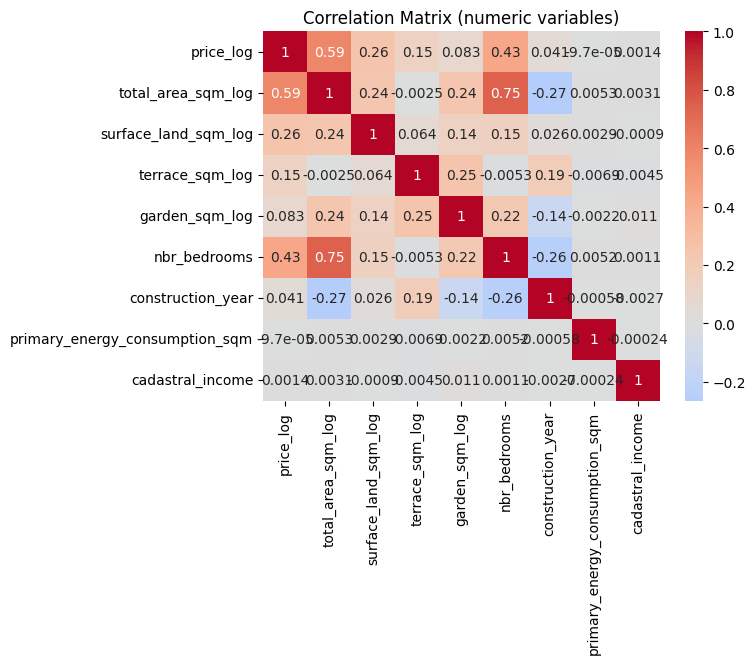

In [ ]:
#Visual 1 - correlation between everything
# Corr between price and continuous (numeric) variables (Correlation Matrix)
import matplotlib.pyplot as plt

#Numeric vars
num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm','cadastral_income']

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (numeric variables)")
plt.show()

In [7]:
# which regions/ provinces have the highest median prices

df.groupby('region')['price'].median().sort_values(ascending=False)

region
MISSING             509500.0
Brussels-Capital    380000.0
Flanders            351063.0
Wallonia            270000.0
Name: price, dtype: float64

In [8]:
# Holistic .corr Analysis with Numeric/log-tranformed variables
'''
Interpretation
Pearson r:
0.0–0.3 -> weak correlation
0.3–0.6 -> moderate correlation
0.6–0.9 -> strong correlation
0.9+ -> very strong correlation
p-value:
Small p (<0.05) -> correlation is statistically significant
Large p (≥0.05) -> not significant; could be noise
'''

from scipy.stats import pearsonr

num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm', 'cadastral_income']

rows = []

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        if i <= j:  # avoid repeating pairs
            r, p = pearsonr(df[col1].fillna(0), df[col2].fillna(0))  # fill NA safely
            rows.append({'Variable 1': col1,'Variable 2': col2,'Pearson r': r,'p-value': p})

# Convert to DataFrame
corr_table = pd.DataFrame(rows)

# Sort by correlation with price
price_corr = corr_table[corr_table['Variable 1']=='price_log'].sort_values(by='Pearson r', ascending=False)
price_corr

,Variable 1,Variable 2,Pearson r,p-value
0,price_log,price_log,1.000000,0.000000e+00
5,price_log,nbr_bedrooms,0.434123,0.000000e+00
1,price_log,total_area_sqm_log,0.246141,0.000000e+00
2,price_log,surface_land_sqm_log,0.231651,0.000000e+00
6,price_log,construction_year,0.139895,0.000000e+00
3,price_log,terrace_sqm_log,0.104517,2.203799e-182
4,price_log,garden_sqm_log,0.078685,5.408231e-104
7,price_log,primary_energy_consumption_sqm,-0.000646,8.590053e-01
8,price_log,cadastral_income,-0.000768,8.327547e-01


In [9]:
# Inter-numeric-variables correaltions - detect possible multicollinearity in regressions later on

corr_matrix = df[num_cols].corr(method='pearson')  # Pearson by default
corr_matrix
corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index())
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Pearson r']
corr_pairs = corr_pairs.sort_values(by='Pearson r', ascending=False)
corr_pairs

,Variable 1,Variable 2,Pearson r
11,total_area_sqm_log,nbr_bedrooms,0.745878
0,price_log,total_area_sqm_log,0.592676
4,price_log,nbr_bedrooms,0.434123
1,price_log,surface_land_sqm_log,0.257446
21,terrace_sqm_log,garden_sqm_log,0.248771
10,total_area_sqm_log,garden_sqm_log,0.240850
8,total_area_sqm_log,surface_land_sqm_log,0.236721
26,garden_sqm_log,nbr_bedrooms,0.220206
23,terrace_sqm_log,construction_year,0.191833
17,surface_land_sqm_log,nbr_bedrooms,0.151745


## Visuals ## 

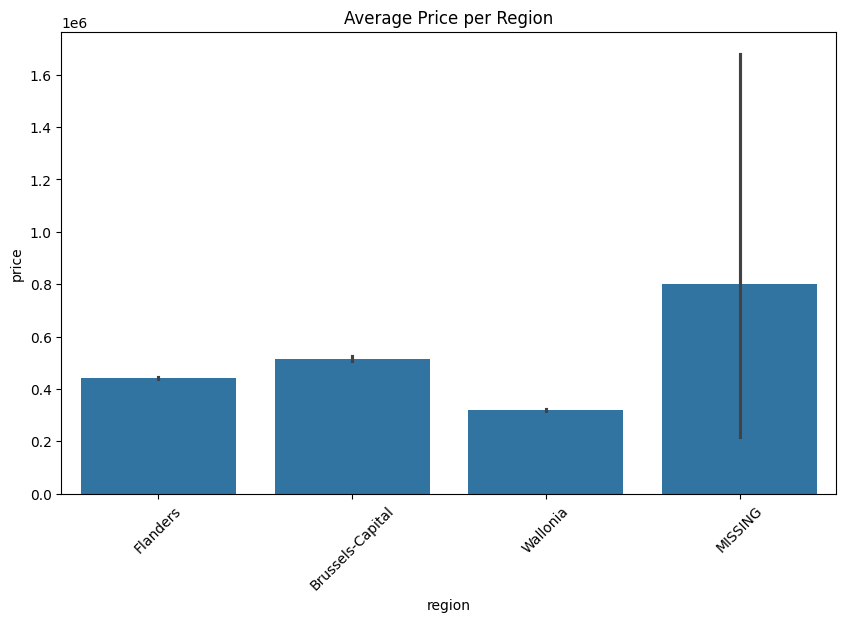

In [ ]:
#Visual 2 - Mean Pice per region 
#On average(mean) how expensive are properties in each region
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="region", y="price", estimator="mean")
plt.title("Average Price per Region")
plt.xticks(rotation=45)
plt.show()



Now without the missing values 

In [16]:
df_no_missing = df[df["region"] != "MISSING"]





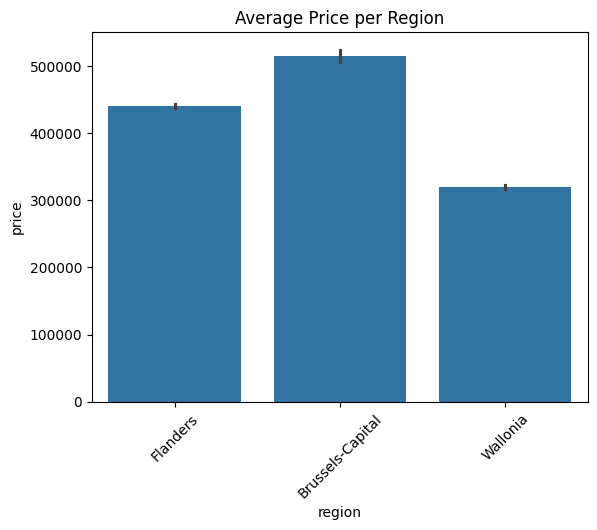

In [19]:
sns.barplot(data=df_no_missing, x="region", y="price")
plt.xticks(rotation=45)
plt.title("Average Price per Region")
plt.show()



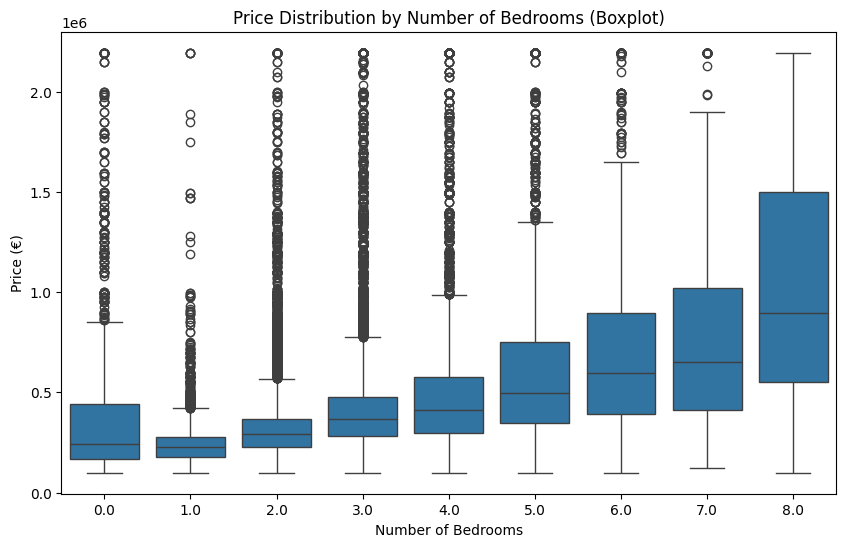

In [ ]:
#Visual 3 - Price by number of bedrooms
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="nbr_bedrooms", y="price")

plt.title("Price Distribution by Number of Bedrooms (Boxplot)")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price (€)")
plt.show()



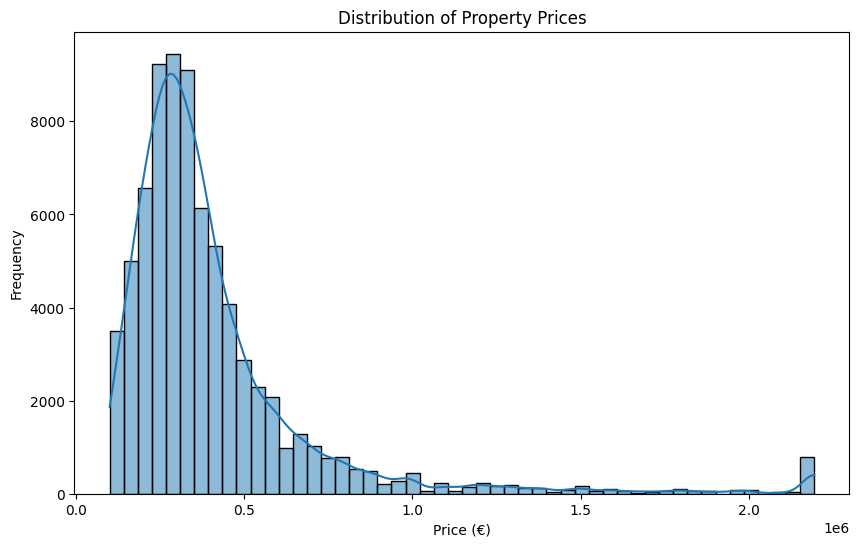

In [ ]:
#Shows skewness of prices.
#Also helps justify log transformation.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df["price"], bins=50, kde=True)

plt.title("Distribution of Property Prices")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.show()


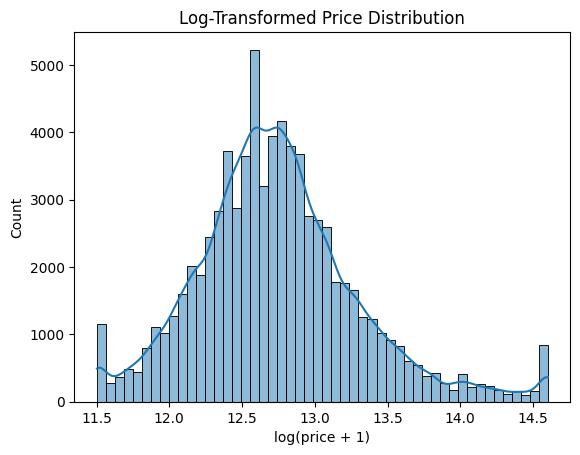

In [ ]:
#For a more normal shape, using log-transform
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)
plt.title("Log-Transformed Price Distribution")
plt.xlabel("log(price + 1)")
plt.show()


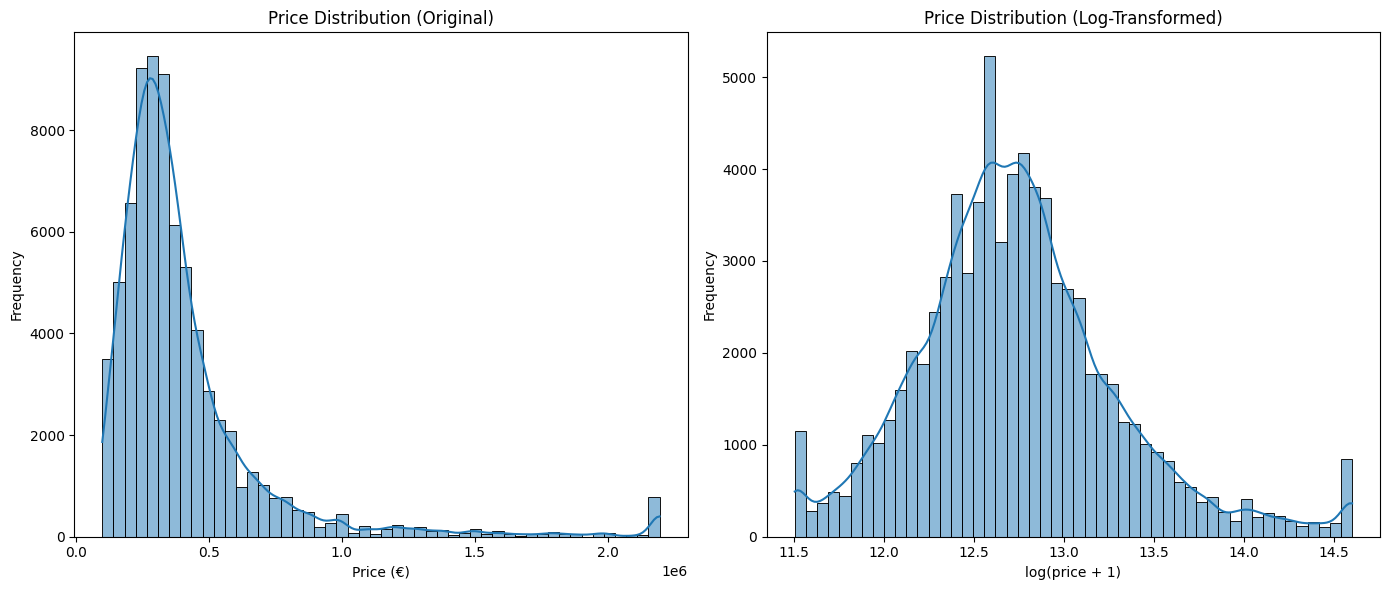

In [25]:
#Comparrison before and after the log-transform
plt.figure(figsize=(14,6))

# ----------------------------
# 1. BEFORE LOG TRANSFORMATION
# ----------------------------
plt.subplot(1, 2, 1)
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price Distribution (Original)")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")

# ----------------------------
# 2. AFTER LOG TRANSFORMATION
# ----------------------------
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df["price"]), bins=50, kde=True)
plt.title("Price Distribution (Log-Transformed)")
plt.xlabel("log(price + 1)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Left Plot → Original Prices
Very right-skewed
Long tail because of luxury houses
Hard to see normal/typical prices

Right Plot → Log-Transformed
Becomes more bell-shaped / normal
Reduces impact of extreme high prices
Makes correlations & ML models more stable